# Post-processing with FESTIM: derived quantities
In this tutorial, we will show the wide range of derived quantities that can be computed as a post process in FESTIM and how to plot them with matplotlib.

## 1. Problem definition

The test case for this tutorial will be a 2D composite domain with 2 traps.

 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104911125-a85da380-598a-11eb-9ba2-9e105f478759.jpg" width="40%">
</p>


- $\Omega = [0;10^{-7}] \times [0;10^{-7}]$
- $\Omega_2 = [5\times 10^{-8};10^{-7}] \times [5\times 10^{-8};10^{-7}]$
- $\Omega_1 = \Omega \; / \; \Omega_2$
- $D(T) = \begin{cases}
    4.1\times 10^{-7} \exp{(-0.39/k_B T)}, & \text{on } \Omega_1\\
    5.0\times 10^{-7} \exp{(-0.50/k_B T)}, & \text{on } \Omega_2
    \end{cases}$
- Trap 1 in $\Omega_1$:
    - Density: $n_1 = 6\times 10^{25} \text{ m}^{-3}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 10^{13} \exp{(-0.87/k_B T)} \text{ s}^{-1}$
- Trap 2 in $\Omega_2$:
    - Density: $n_2 = 6\times 10^{25} \text{ m}^{-3}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 10^{13} \exp{(-1.0/k_B T)} \text{ s}^{-1}$

Two Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ and $\Gamma_\mathrm{bottom}$.

- $c_\mathrm{m} = 10^{15} \; \mathrm{m}^{-3} \quad \text{on } \Gamma_\mathrm{left}$
- $c_\mathrm{m} = 0 \; \mathrm{m}^{-3} \quad \text{on }\Gamma_\mathrm{bottom}$

All the other surfaces are insulated ($\nabla c_\mathrm{m} \cdot n = 0$).

## 2. Implementation
The first step is to create a FESTIM Simulation object

In [17]:
import FESTIM as F

my_model = F.Simulation()

Then, let's create a mesh using FEniCS commands.

In [18]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction

# creating a 2D mesh with FEniCS
nx = ny = 14
mesh_fenics = RectangleMesh(Point(0, 0), Point(1e-7, 1e-7), nx, ny)

# marking volumes
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())

volume_markers.set_all(1)

tol = 1e-14

subdomain_2 = CompiledSubDomain('x[1] >= 0.5e-7 - tol && x[0] >= 0.5e-7 - tol', tol=tol)
subdomain_2.mark(volume_markers, 2)

# marking surfaces
surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)

left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
bottom_surface.mark(surface_markers, 2)

# creating mesh with FESTIM
my_model.mesh = F.Mesh(
    mesh=mesh_fenics,
    volume_markers=volume_markers,
    surface_markers=surface_markers
)

The two materials will have different diffusion coefficients.

In [19]:
my_model.materials = F.Materials([
    F.Material(
        D_0=4.1e-07,
        E_D=0.39,
        id=1
    ),
    F.Material(
        D_0=5e-07,
        E_D=0.5,
        id=2
    )
])

The same traps as in the Ogorodnikova demo will be used.

In [20]:
my_model.traps = F.Traps([
    F.Trap(
        k_0=3.8e-17,
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        density=6e25,
        materials=1
    ),
    F.Trap(
        k_0=3.8e-17,
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        density=5e24,
        materials=2
    )
])

Two Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ (id 1) and $\Gamma_\mathrm{bottom}$ (id 2).

- $c_\mathrm{m} = 10^{15} \; \mathrm{m}^{-3} \text{  on } \Gamma_\mathrm{left}$
- $c_\mathrm{m} = 0 \; \mathrm{m}^{-3} \text{  on }\Gamma_\mathrm{bottom}$

All the other surfaces are insulated ($\nabla c_\mathrm{m} \cdot n = 0$).

In [21]:
my_model.boundary_conditions = [
    F.DirichletBC(
        surfaces=1,
        value=1e15
    ),
    F.DirichletBC(
        surfaces=2,
        value=0
    )
]

The temperature will increase linearly with time: $T(t) = 400 + 3t$ 

In [22]:
my_model.T = F.Temperature(
    value=400 + 3*F.t
)

In [23]:
my_model.dt = F.Stepsize(
    initial_value=0.005,
    stepsize_change_ratio=1.1,
    dt_min=1e-05
)

my_model.settings = F.Settings(
    absolute_tolerance=1e0,
    relative_tolerance=1e-09,
    maximum_iterations = 50,
    final_time=10,
    traps_element_type="DG"
)

FESTIM can provide a wide range of post-processing quantities called `derived quantities`.
They include:
- Volume integration (`TotalVolume`)
- Surface integration (`TotalSurface`)
- Surface fluxes (`SurfaceFlux`)
    - Heat fluxes : $ \varphi = \int -\lambda \nabla T \cdot n \; dS $
    - Particle fluxes : $ \varphi = \int -D \nabla c_\mathrm{m} \cdot n \; dS $
- Average value on volumes (`AverageVolume`)
- Minimum/maximum on volumes (`MinimumVolume`, `MaximumVolume`)

In [24]:
my_derived_quantities = F.DerivedQuantities(
    file="derived_quantities.csv",
    folder="solution_derived_quantities"
)

my_derived_quantities.derived_quantities = [
    F.TotalVolume("solute", volume=1),
    F.TotalVolume("solute", volume=2),
    F.TotalVolume("retention", volume=1),
    F.TotalVolume("retention", volume=2),
    F.TotalVolume("1", volume=1),
    F.TotalVolume("2", volume=2),
    F.HydrogenFlux(surface=0),
    F.HydrogenFlux(surface=1),
    F.HydrogenFlux(surface=2),
    F.AverageVolume("solute", volume=1),
    F.AverageVolume("1", volume=1),
    F.AverageVolume("2", volume=2),
    F.AverageVolume("T", volume=1),
    F.TotalSurface("solute", surface=0),
    F.TotalSurface("solute", surface=1),
    F.TotalSurface("solute", surface=2),
    F.MaximumVolume("retention", volume=1),
    F.MaximumVolume("retention", volume=2)
]

my_model.exports = F.Exports([
    my_derived_quantities
])

Now that all the parameters have been set, the simulation can be initialised using the `initialise()` function and performed using the `run()` function

In [25]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Solved problem in 3.20 s    Ellapsed time so far: 3.2 s


## 3. Post-processing
Now that the simulation is over, the derived quantities are stored in `my_derived_quantities` and have been exported as a CSV file.

In [26]:
import numpy as np

header = my_derived_quantities.data[0]
derived_quantities = np.array(my_derived_quantities.data[1:])

print(header)
print(derived_quantities)

['t(s)', 'Total solute volume 1', 'Total solute volume 2', 'Total retention volume 1', 'Total retention volume 2', 'Total 1 volume 1', 'Total 2 volume 2', 'Flux surface 0: solute', 'Flux surface 1: solute', 'Flux surface 2: solute', 'Average solute volume 1', 'Average 1 volume 1', 'Average 2 volume 2', 'Average T volume 1', 'Total solute surface 0', 'Total solute surface 1', 'Total solute surface 2', 'Maximum retention volume 1', 'Maximum retention volume 2']
[[  5.00000000e-03   1.47721291e+00   4.19917028e-02 ...,   0.00000000e+00
    9.09204542e+16   1.06162157e+15]
 [  1.05000000e-02   1.72117520e+00   6.91835314e-02 ...,   0.00000000e+00
    1.52667228e+17   2.80754158e+15]
 [  1.65500000e-02   1.94674053e+00   9.79224550e-02 ...,   0.00000000e+00
    1.93489694e+17   5.44344334e+15]
 ..., 
 [  8.54359739e+00   3.75058154e+00   1.29117604e+00 ...,   0.00000000e+00
    1.11044826e+17   2.58963337e+17]
 [  9.40295712e+00   3.74908365e+00   1.28343376e+00 ...,   0.00000000e+00
    1.

Alternatively, the derived quantities can be read from the exported CSV file.

In [27]:
derived_quantities = np.genfromtxt("solution_derived_quantities/derived_quantities.csv", delimiter=',', names=True)

These derived quantities can be analysed and plotted using matplotlib (or some other visualisation tool).

Below are some examples.

**Plotting inventories**

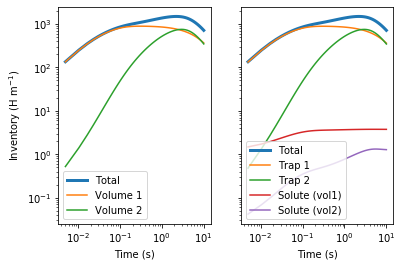

In [28]:
t = derived_quantities["ts"]

retention_1 = derived_quantities['Total_retention_volume_1']
retention_2 = derived_quantities['Total_retention_volume_2']

trap_1 = derived_quantities['Total_1_volume_1']
trap_2 = derived_quantities['Total_2_volume_2']

solute_1 = derived_quantities['Total_solute_volume_1']
solute_2 = derived_quantities['Total_solute_volume_2']

# plot
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(t, retention_1 + retention_2, linewidth=3, label="Total")
ax1.plot(t, retention_1, label="Volume 1")
ax1.plot(t, retention_2, label="Volume 2")
ax1.set_ylabel(r"Inventory (H m$^{-1}$)")
ax1.set_xlabel(r"Time (s)")
ax1.set_xscale("log")
ax1.legend()

ax2.plot(t, retention_1 + retention_2, linewidth=3, label="Total")
ax2.plot(t, trap_1, label="Trap 1")
ax2.plot(t, trap_2, label="Trap 2")
ax2.plot(t, solute_1, label="Solute (vol1)")
ax2.plot(t, solute_2, label="Solute (vol2)")
ax2.set_xlabel(r"Time (s)")
ax2.legend()
ax2.set_xscale("log")

ax1.set_yscale("log")

**Plotting fluxes**

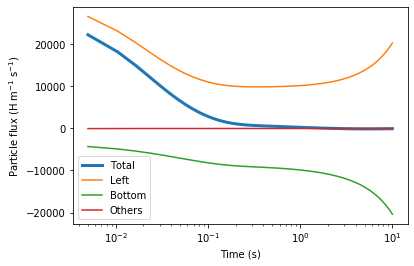

In [29]:
flux_other_surfaces = derived_quantities['Flux_surface_0_solute']
flux_left = derived_quantities['Flux_surface_1_solute']
flux_bottom = derived_quantities['Flux_surface_2_solute']
flux_total = flux_left + flux_bottom + flux_other_surfaces

plt.figure()
plt.plot(t, flux_total, linewidth=3, label="Total")
plt.plot(t, flux_left, label="Left")
plt.plot(t, flux_bottom, label="Bottom")
plt.plot(t, flux_other_surfaces, label="Others")
plt.ylabel(r"Particle flux (H m$^{-1}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.xscale("log")
plt.legend()

**Plotting maximum retention**

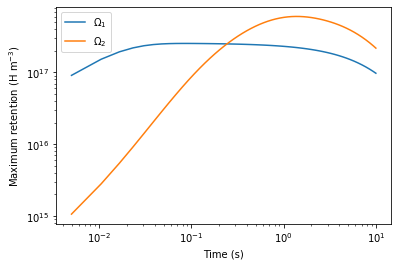

In [30]:
max_1 = derived_quantities['Maximum_retention_volume_1']
max_2 = derived_quantities['Maximum_retention_volume_2']

plt.figure()
plt.loglog(t, max_1, label=r"$\Omega_1$")
plt.loglog(t, max_2, label=r"$\Omega_2$")
plt.ylabel(r"Maximum retention (H m$^{-3}$)")
plt.xlabel(r"Time (s)")
plt.legend()

**Ploting average temperature**

Text(0.5, 0, 'Time (s)')

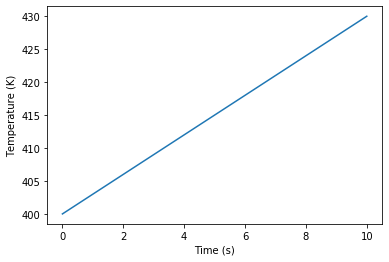

In [31]:
T = derived_quantities['Average_T_volume_1']

plt.figure()
plt.plot(t, T)  
plt.ylabel(r"Temperature (K)")
plt.xlabel(r"Time (s)")

**Plotting inventory on surfaces**

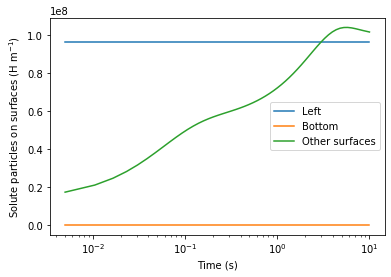

In [32]:
solute_surf_0 = derived_quantities['Total_solute_surface_0']
solute_surf_1 = derived_quantities['Total_solute_surface_1']
solute_surf_2 = derived_quantities['Total_solute_surface_2']

plt.figure()
plt.plot(t, solute_surf_1, label="Left")
plt.plot(t, solute_surf_2, label="Bottom")
plt.plot(t, solute_surf_0, label="Other surfaces")
plt.ylabel(r"Solute particles on surfaces (H m$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.xscale("log")
plt.legend()